In [6]:
# CALCULATE GROUND TRUTH

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from stoch_mcts.agent.agent import Agent
from stoch_mcts.game.game import ContinuousBlackJack
import stoch_mcts.trainer.trainer as train
import stoch_mcts.mcts.mcts as mcts_
from stoch_mcts.mcts.graph import Node
from stoch_mcts.mcts.path import Path
import stoch_mcts.mcts.backpropagator as bkprop
import stoch_mcts.mcts.evaluator as ev
import stoch_mcts.mcts.selector as sel
# from stoch_mcts.mcts.selector import selector.
# from stoch_mcts.mcts import ActionSelector

ground_truth_n_samples = 10_000_000
n_trials = 500
num_rollouts = [10, 20, 50, 100, 200, 500]
pw_factors = [0.5, 1, 2, 5, 10, 20, 50, 100]
pw_exponents = [0.1, 0.3, 0.5, 0.7, 0.9]
ar_factor = 2
ar_exponent = -0.1

env = ContinuousBlackJack()
act_sel: sel.ActionSelector = sel.wikipedia_policy
state_sel: sel.StateSelector = sel.ProgressiveWidening(k=2,alpha=-0.1)
selector = sel.Selector(act_sel,state_sel)
evaluator: ev.Evaluator = ev.null
back_prop = bkprop.TreeBackpropagator(discount=0.1)
mcts = mcts_.MCTS(selector,evaluator,back_prop)
agent = Agent(mcts)

# AR agent
state_sel_ar: sel.StateSelector = sel.AbstractionRefining(k=ar_factor,alpha=ar_exponent,dist=env.distance)
selector_ar = sel.Selector(act_sel,state_sel_ar)
mcts_ar = mcts_.MCTS(selector_ar,evaluator,back_prop)
agent_ar = Agent(mcts_ar)

ground_truth = train.run(env,agent,num_episodes=ground_truth_n_samples,n_rollouts=0)

In [3]:
# ground_truth = -0.0668002
print(np.average(ground_truth))

-0.0668002


Plot main figure (paper): AR and PW value error (with modification on the 'run' function) 

In [20]:
# BLACKJACK MAIN PLOT (paper)

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st

from stoch_mcts.agent.agent import Agent
from stoch_mcts.game.game import ContinuousBlackJack
import stoch_mcts.trainer.trainer as train
import stoch_mcts.mcts.mcts as mcts_
from stoch_mcts.mcts.graph import Node
from stoch_mcts.mcts.path import Path
import stoch_mcts.mcts.backpropagator as bkprop
import stoch_mcts.mcts.evaluator as ev
import stoch_mcts.mcts.selector as sel

ground_truth = -0.0668002

ar_factor = 2
ar_exponent = -0.1

env = ContinuousBlackJack()
act_sel: sel.ActionSelector = sel.wikipedia_policy
back_prop = bkprop.TreeBackpropagator(discount=0.1)

# AR agent
state_sel_ar: sel.StateSelector = sel.AbstractionRefining(k=ar_factor,alpha=ar_exponent,dist=env.distance)
selector_ar = sel.Selector(act_sel,state_sel_ar)
evaluator_ar: ev.Evaluator = ev.null
mcts_ar = mcts_.MCTS(selector_ar,evaluator_ar,back_prop)
agent_ar = Agent(mcts_ar)

n_trials = 100
num_rollouts = [10, 20, 50, 100, 200, 500, 1000]
pw_factors = [1, 2, 3, 4]
pw_exponents = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 1]
max_e = len(pw_exponents)

df = {'method': [], 'value_error': [], 'return': [], 'num_rollouts': [], 'k': [], 'exp': []}

for e_idx in range(8):
  e = pw_exponents[e_idx]
  df['method'].append(f'PW{e}')
  df['num_rollouts'].append(num_rollouts[0])
  df['value_error'].append(-1)
  df['exp'].append(e)
  df['k'].append(pw_factors[0])
  df['return'].append(200)

for nr in num_rollouts:
  for k in pw_factors:
    start_idx = 0    
    end_idx = max_e
    step = 1
    if k==pw_factors[0]:
      start_idx = 11
      end_idx = 16
    if k==pw_factors[1]:
      start_idx = 1
      end_idx = 6
    if k==pw_factors[2]:
      start_idx = 2
      end_idx = 7
    if k==pw_factors[3]:
      start_idx = 0
      end_idx = 5
    for e_idx in range(start_idx, end_idx, step):
      e = pw_exponents[e_idx]
      state_sel_pw: sel.StateSelector = sel.ProgressiveWidening(k,alpha=e)
      selector_pw = sel.Selector(act_sel,state_sel_pw)
      evaluator_pw: ev.Evaluator = ev.null
      back_prop_pw = bkprop.TreeBackpropagator(discount=0.1)
      mcts_pw = mcts_.MCTS(selector_pw,evaluator_pw,back_prop_pw)
      agent_pw = Agent(mcts_pw)
      PW = train.run(env,agent_pw,num_episodes=n_trials,n_rollouts=nr)
      abs_pw = [abs(ele) for ele in PW]
      pw_mean = np.average(abs_pw)
      ci = st.t.interval(alpha=0.95, df=len(PW)-1, loc=pw_mean, scale=st.sem(abs_pw)) 
      df['method'].append(f'PW{e}')
      df['num_rollouts'].append(nr)
      df['exp'].append(e)
      df['k'].append(k)
      df['return'].append(np.average(abs_pw))
      df['value_error'].append(np.average(abs_pw) - ground_truth)
      df['method'].append(f'PW{e}')
      df['num_rollouts'].append(nr)
      df['exp'].append(e)
      df['k'].append(k)
      df['return'].append(ci[0])
      df['value_error'].append(ci[0] - ground_truth)
      df['method'].append(f'PW{e}')
      df['num_rollouts'].append(nr)
      df['exp'].append(e)
      df['k'].append(k)
      df['return'].append(ci[1])
      df['value_error'].append(ci[1] - ground_truth)
    AR = train.run(env,agent_ar,num_episodes=n_trials,n_rollouts=nr)
    abs_ar = [abs(ele) for ele in AR]
    ar_mean = np.average(abs_ar)
    ci = st.t.interval(alpha=0.95, df=len(AR)-1, loc=ar_mean, scale=st.sem(abs_ar)) 
    df['method'].append('AR')
    df['num_rollouts'].append(nr)
    df['exp'].append(ar_exponent)
    df['k'].append(k)
    df['return'].append(np.average(abs_ar))
    df['value_error'].append(np.average(abs_ar) - ground_truth)
    df['method'].append('AR')
    df['num_rollouts'].append(nr)
    df['exp'].append(ar_exponent)
    df['k'].append(k)
    df['return'].append(ci[0])
    df['value_error'].append(ci[0] - ground_truth)
    df['method'].append('AR')
    df['num_rollouts'].append(nr)
    df['exp'].append(ar_exponent)
    df['k'].append(k)
    df['return'].append(ci[1])
    df['value_error'].append(ci[1] - ground_truth)

df_ = pd.DataFrame(df)
plt.close()
df_.to_pickle('blackjack_df_def.pkl')
# df_['value_error'] = df_['value_error'].astype(float)
ax = sns.relplot(data=df_, x='num_rollouts', y='value_error', hue='method', kind='line', col='k', facet_kws={'sharey': True, 'sharex': True})
# ax.set(ylim=(0, 0.5))
ax.set(yscale="log")
plt.show()
# plt.savefig('results/blackjack/value_error_test.png')
# plt.savefig('results/blackjack/value_error_test.pdf')
# plt.close()


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]
/home/riccardo/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


Plot dataframe with viridis palette

/tmp/ipykernel_630/2253726747.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = data1.append(data2, ignore_index=True)
/tmp/ipykernel_630/2253726747.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df1.append(data3, ignore_index=True)
/tmp/ipykernel_630/2253726747.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df2.append(data4, ignore_index=True)


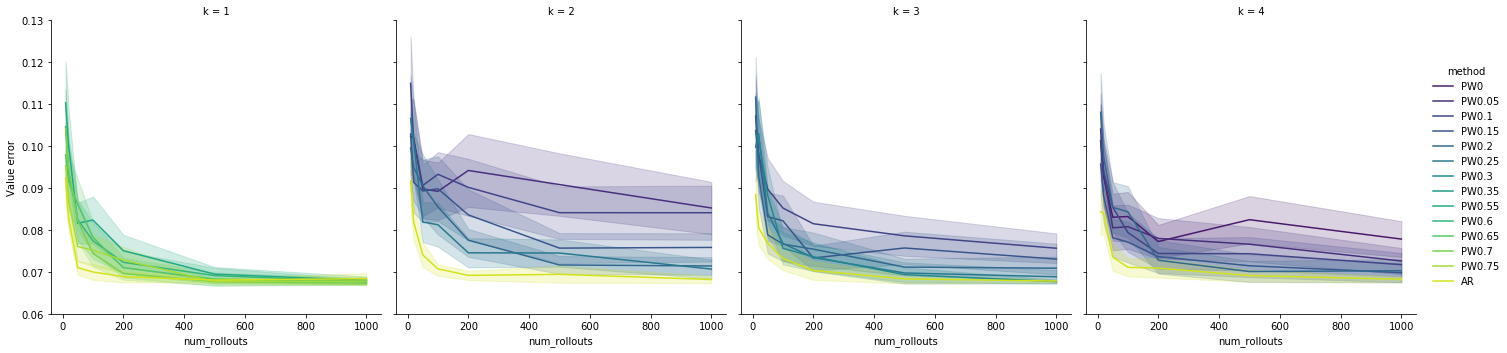

In [6]:
# PLOT BLACKJACK RESULTS

import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import pandas as pd

with open('blackjack_df_test_k1.pkl', 'rb') as f:
    data1 = pickle.load(f)
with open('blackjack_df_test_k2.pkl', 'rb') as f:
    data2 = pickle.load(f)
with open('blackjack_df_test_k3.pkl', 'rb') as f:
    data3 = pickle.load(f)
with open('blackjack_df_test_k4.pkl', 'rb') as f:
    data4 = pickle.load(f)

# method_list = data1['value_error']
# PW_indexes = [x for x in range(len(method_list)) if method_list[x] == -1]
# print(PW_indexes)
# data1.drop(PW_indexes, axis=0, inplace=True)
method_list = data2['value_error']
PW_indexes = [x for x in range(len(method_list)) if method_list[x] == -1]
data2.drop(PW_indexes, axis=0, inplace=True)
method_list = data3['value_error']
PW_indexes = [x for x in range(len(method_list)) if method_list[x] == -1]
data3.drop(PW_indexes, axis=0, inplace=True)
method_list = data4['value_error']
PW_indexes = [x for x in range(len(method_list)) if method_list[x] == -1]
data4.drop(PW_indexes, axis=0, inplace=True)

df1 = data1.append(data2, ignore_index=True)
df2 = df1.append(data3, ignore_index=True)
data = df2.append(data4, ignore_index=True)

g = sns.relplot(data=data, x='num_rollouts', y='value_error', hue='method', kind='line', col='k', palette='viridis', facet_kws={'sharey': True, 'sharex': True})
g.set(ylim=(0.06, 0.13))
ax.set(yscale="log")
g.set(ylabel="Value error")
plt.show()

Plot debug 

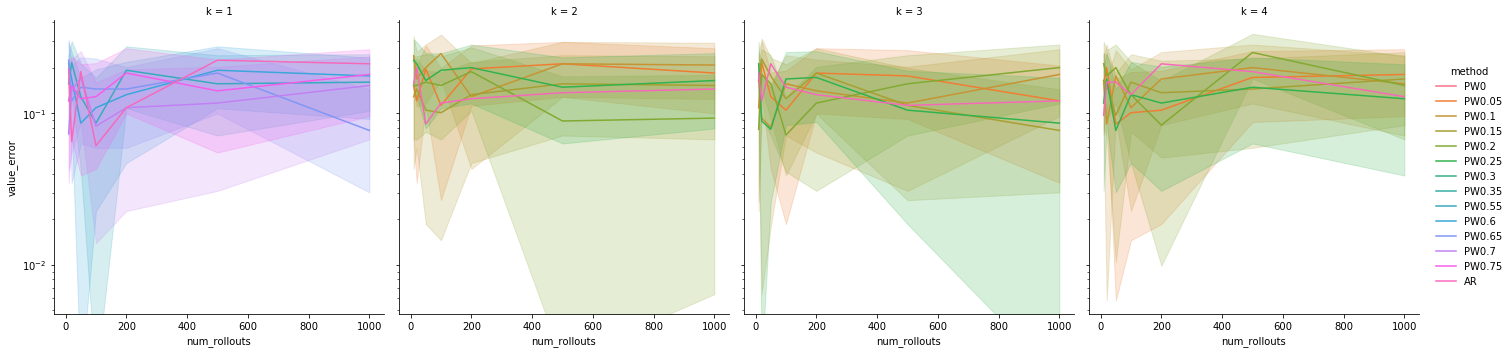

In [16]:
# PLOT BLACKJACK SINGLE k 

import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
import pandas as pd

with open('blackjack_df.pkl', 'rb') as f:
    df_ = pickle.load(f)

# df_ = pd.DataFrame(df)
df_['value_error'] = df_['value_error'].astype(float)
method_list = df_['method']
AR_indexes = [x for x in range(len(method_list)) if method_list[x] == 'AR']
AR_rows = df_.iloc[AR_indexes]
PW_indexes = [x for x in range(len(method_list)) if method_list[x] != 'AR']
PW_rows = df_.iloc[PW_indexes]

y = df_['value_error']
ax = sns.relplot(data=df_, x='num_rollouts', y=y, hue='method', kind='line', col='k', facet_kws={'sharey': True, 'sharex': True})
# ax.set(ylim=(0.02, 0.1))
ax.set(yscale="log")
plt.show()